In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from uplift_dgf import get_daily_visitors, get_daily_conversions, get_conversions_array, grid_configs
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.weightstats import ttest_ind

In [2]:
# Set plot options
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

In [4]:
# Create random generator
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

### Fixed parameters

In [5]:
# Avg. visitors per day & its noise, as Poisson distributions
lam_visitors = 100
lam_visitors_noise = 5

In [6]:
# Conversion rates
conversion_control = 0.15
conversion_experiment = 0.20

# Noise in conversion rates, as Beta distribution
# Mean = alpha / (alpha + beta)
conversion_noise_alpha = 3  
conversion_noise_beta = 100

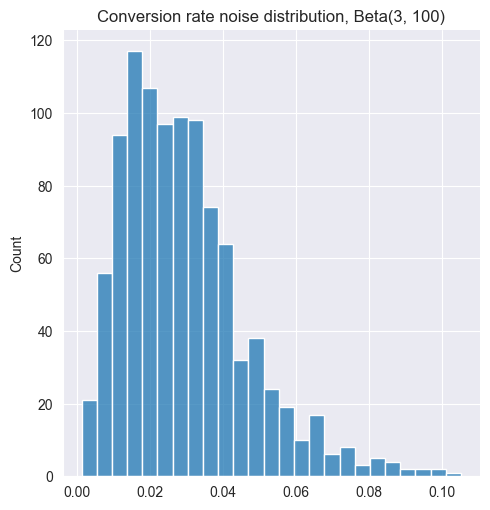

In [7]:
# Test conversion rate noise generation (will be randomly negated)
sns.displot(
    np.random.beta(conversion_noise_alpha, conversion_noise_beta, 1000)
)
_ = plt.title(f"Conversion rate noise distribution, Beta({conversion_noise_alpha}, {conversion_noise_beta})")

### Data generating functions

In [8]:
# Test daily visitors generation
n_test_days = 5
test_visitors = get_daily_visitors(n_test_days, lam_visitors, lam_visitors_noise, rng)
test_visitors

array([123,  97, 104,  89,  91], dtype=int64)

In [9]:
# Test daily conversions generation
test_conversions = get_daily_conversions(
    test_visitors, 
    conversion_control, 
    conversion_noise_alpha, 
    conversion_noise_beta, 
    rng
)
test_conversions

array([17, 16, 12, 16, 16])

In [10]:
# Test conversions array generation
test_array = get_conversions_array(
    test_visitors,
    test_conversions
)
test_array

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [11]:
# Test calculating conversion rate
np.mean(test_array)


0.1527777777777778

In [12]:
# Test calculating sample standard deviation
np.std(test_array)


0.3597731624163505

## Power analysis

In [13]:
# Minimum practically significant raw effect size
min_raw_effect = conversion_experiment - conversion_control

# Expected sample standard deviation
expected_std = 0.3

# Minimum practically significant standardized effect
min_std_effect = (min_raw_effect / expected_std)

# Considered standardized effect sizes
effect_sizes = [
    min_std_effect * 0.5, 
    min_std_effect * 0.8, 
    min_std_effect, 
    min_std_effect * 1.2,
    min_std_effect * 1.5
    ]

# Considered significance levels
alphas = [0.01, 0.05, 0.10]

# Considered n. of days
n_days = np.arange(1, 22, 1)

# Dictionary of parameters
dict_power = {
    "effect_size": effect_sizes,
    "alpha": alphas,
    "n_days": n_days
}

In [14]:
# Create power calculator
power_calc = TTestIndPower(alternative = "larger")

In [16]:
# Calculate power for each parameter combination
effects_list = []
alphas_list = []
days_list = []
power_list = []
for config in grid_configs(dict_power):

    # Calculate power
    n_obs = np.sum(
        get_daily_visitors(config["n_days"], lam_visitors, lam_visitors_noise, rng)
        )

    power = power_calc.power(
        effect_size = config["effect_size"],
        nobs1 = n_obs,
        alpha = config["alpha"],
        ratio = 1
    )

    # Append parameters to list
    effects_list.append(config["effect_size"])
    alphas_list.append(config["alpha"])
    days_list.append(config["n_days"])
    power_list.append(power)

In [17]:
# Create dataframe of power calculations
power_data = pd.DataFrame({
    "effect_size": [round(x, 2) for x in effects_list],
    "alpha": [round(x, 2) for x in alphas_list],
    "days": days_list,
    "power": [round(x, 2) for x in power_list]
})

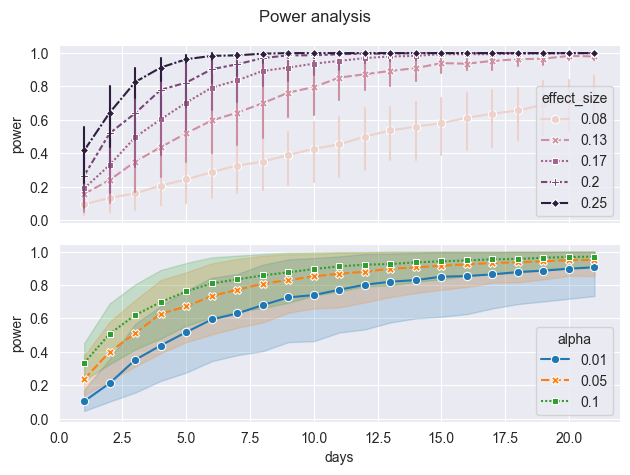

In [18]:
# Plot power vs. variables
fig, ax = plt.subplots(2, sharey = True, sharex = True)
plt.suptitle("Power analysis")

_ = sns.lineplot(
    power_data,
    x = "days",
    y = "power",
    hue = "effect_size",
    style = "effect_size",
    markers = True,
    err_style = "bars",
    ax = ax[0]
)

_ = sns.lineplot(
    power_data,
    x = "days",
    y = "power",
    hue = power_data["alpha"].astype(str),
    style = power_data["alpha"].astype(str),
    markers = True,
    ax = ax[1]
)

To detect the minimum standardized effect size with a power of ~0.8-0.9 at significance 0.05, we need 6-7 days.

Can calculate the required sample size for a given power, significance & standardized effect size using `TTestIndPower.solve_power`.

## T-tests

In [19]:
class TTest:

    def __init__(self, effect_size,  alpha = 0.05):
        self.effect_size = effect_size
        self.alpha = alpha
    
    def _run_test(self, days):

        # Generate control data
        control_daily_visitors = get_daily_visitors(days, lam_visitors, lam_visitors_noise, rng)
        control_daily_conversions = get_daily_conversions(
            control_daily_visitors, 
            conversion_control, 
            conversion_noise_alpha, 
            conversion_noise_beta,
            rng
            )
        control_array = get_conversions_array(control_daily_visitors, control_daily_conversions)
        n_obs_control = len(control_array)

        # Generate experiment data
        experiment_daily_visitors = get_daily_visitors(days, lam_visitors, lam_visitors_noise, rng)
        experiment_daily_conversions = get_daily_conversions(
            experiment_daily_visitors, 
            conversion_experiment, 
            conversion_noise_alpha, 
            conversion_noise_beta,
            rng
            )
        experiment_array = get_conversions_array(experiment_daily_visitors, experiment_daily_conversions)
        n_obs_experiment = len(experiment_array)

        # Perform test
        # "alternative" relates first sample to the second
        t, p, df = ttest_ind(
            experiment_array,
            control_array,
            alternative = "larger",
            usevar = "unequal"
            )
        
        # Calculate power
        power = power_calc.power(
            effect_size = self.effect_size,
            nobs1 = n_obs_control,
            alpha = self.alpha,
            ratio = n_obs_experiment / n_obs_control
        )

        return n_obs_control, n_obs_experiment, t, p, df, power

    def single_test(self, days):

        # Run test        
        n_obs_control, n_obs_experiment, t, p, df, power = self._run_test(days)

        # Print results
        print(f"N. of days: {days}")
        print(f"N. of control samples: {n_obs_control}")
        print(f"N. of experiment samples: {n_obs_experiment}")
        print(f"T-stat: {t}")
        print(f"P-value: {p}")
        print(f"Deg. of freedom: {df}")
        print(f"Power: {power}, at significance {self.alpha}, for std. effect size {self.effect_size}")
    
    def multiple_tests(self, days, trials = 1000):

        false_negatives = 0
        p_values = []
        powers = []
        for i in range(trials):
            n_obs_control, n_obs_experiment, t, p, df, power = self._run_test(days)
            p_values.append(p)
            powers.append(power)

            if p > self.alpha:
                false_negatives +=1
            
            avg_power = np.mean(powers)
            avg_p = np.mean(p_values)
            fnr = false_negatives / trials
            
        print(f"N. trials: {trials}")
        print(f"Significance level: {self.alpha}")
        print(f"Avg. p-value: {avg_p}")
        print(f"Avg. power: {avg_power}")
        print(f"False negative rate (Type II): {fnr}")
        print(f"Difference of (1-avg. power) and FNR: {(1-avg_power) - fnr}")

In [20]:
ttest = TTest(min_std_effect, alpha = 0.05)

### Single tests

In [21]:
# Underpowered test
ttest.single_test(days = 2)

N. of days: 2
N. of control samples: 219
N. of experiment samples: 213
T-stat: 0.5072205493087084
P-value: 0.3061306355968745
Deg. of freedom: 428.07542298322494
Power: 0.408402076257444, at significance 0.05, for std. effect size 0.16666666666666674


In [22]:
# Adequately powered test
ttest.single_test(days = 6)

N. of days: 6
N. of control samples: 560
N. of experiment samples: 578
T-stat: 1.4279803169857281
P-value: 0.07678645025016384
Deg. of freedom: 1133.8216532371835
Power: 0.8019198210620294, at significance 0.05, for std. effect size 0.16666666666666674


In [23]:
# Overpowered test
ttest.single_test(days = 10)

N. of days: 10
N. of control samples: 1064
N. of experiment samples: 955
T-stat: 1.3674310942151287
P-value: 0.0858232048639847
Deg. of freedom: 1967.4676092685274
Power: 0.9622351697095688, at significance 0.05, for std. effect size 0.16666666666666674


### Multiple tests (simulating multiple datasets)

In [24]:
# Underpowered tests
ttest.multiple_tests(days = 2)

N. trials: 1000
Significance level: 0.05
Avg. p-value: 0.16209896655189515
Avg. power: 0.3816177892411795
False negative rate (Type II): 0.644
Difference of (1-avg. power) and FNR: -0.025617789241179523


In [25]:
# Adequately powered tests
ttest.multiple_tests(days = 6)

N. trials: 1000
Significance level: 0.05
Avg. p-value: 0.04026966793049073
Avg. power: 0.8219277762557912
False negative rate (Type II): 0.22
Difference of (1-avg. power) and FNR: -0.041927776255791166


In [26]:
# Overpowered tests
ttest.multiple_tests(days = 10)

N. trials: 1000
Significance level: 0.05
Avg. p-value: 0.012766243641229214
Avg. power: 0.9607816740376136
False negative rate (Type II): 0.064
Difference of (1-avg. power) and FNR: -0.02478167403761361


Notes:

More noise in the conversion rate -> higher actual FNR in simulation compared to (1- avg. power).

In reality, we do not know the following:

- Exact n. of samples in each group, or their ratio. We only control the number of experiment days and we have to estimate the sample sizes accordingly.
- The standard deviation of the sample outcomes. We have to estimate this from past data or knowledge.